In [ ]:
from rcnn_utils import *
from torch.nn import init
from torchvision.transforms import v2

## Datasets

|Dataset|Type|Model|DICE train|DICE val|Params|
|-|-|-|-|-|-|
|RP500|Plain, Rectangle|RCNN-cell|.358 |.437|898|
|||LSTM-cell|.541|.546|2096|
|||RNN-cell (deeper)|.68|.70||
|||RNN-cell (SegNetDrop)|.46|.41||
|RP1000|Plain, Rectangle||
|RT500|Texture, Rectangle||
|RT1000|Texture, Rectangle||
|PP500|Plain, Polgon|RCNN-cell|.53|.53|898|
|||LSTM-cell|.53|.53|2096|
|PP1000|Plain, Polygon||
|PT500|Texture, Polygon||
|PT1000|Texture, Polygon||

In [9]:
def load_and_split(loader: Dataset, split: list, seed: torch.Generator) -> Data:
    return Data(*random_split(
        loader,
        split,
        seed
    )[:3])

In [10]:
# datasets 
dRP500 = load_and_split(
    BaseRcnnDataset("../data/DRect_plain_1000/data/", "../data/DRect_plain_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dRP1000 = load_and_split(
    BaseRcnnDataset("../data/DRect_plain_1000/data/", "../data/DRect_plain_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

dRT500 = load_and_split(
    BaseRcnnDataset("../data/DRect_texture_1000/data/", "../data/DRect_texture_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dRT1000 = load_and_split(
    BaseRcnnDataset("../data/DRect_texture_1000/data/", "../data/DRect_texture_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

dPP500 = load_and_split(
    BaseRcnnDataset("../data/DPoly_plain_1000/data/", "../data/DPoly_plain_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dPP1000 = load_and_split(
    BaseRcnnDataset("../data/DPoly_plain_1000/data/", "../data/DPoly_plain_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

dPT500 = load_and_split(
    BaseRcnnDataset("../data/DPoly_texture_1000/data/", "../data/DPoly_texture_1000/RCNNAnnotations/"),
    [400, 50, 50, 500],
    torch.Generator().manual_seed(10)
    )

dPT1000 = load_and_split(
    BaseRcnnDataset("../data/DPoly_texture_1000/data/", "../data/DPoly_texture_1000/RCNNAnnotations/"),
    [800, 100, 100],
    torch.Generator().manual_seed(10)
    )

## Models

1. RCNN cell
2. RCNN cell group
3. LSTM-CNN cell
4. LSTM-CNN cell group
5. ?GRU-CNN cell group (with pooling and unpooling and skip layers)

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
    def grad_norm(self):
        total_norm = 0.0
        for param in self.parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2

        return total_norm

### RCNN cell

In [12]:
class UnitProcess(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, in_channels, 5, 1, 2),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        )
        
        init.orthogonal_(self.process[0].weight)
        init.orthogonal_(self.process[-1].weight)
        
    def forward(self, x):
        return self.process(x)
    
class UnitProcess2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.process = nn.Sequential(
          nn.Conv2d(in_channels, in_channels, 5, 1, 2),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels, in_channels*2, 5, 1, 2),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(),
          nn.Conv2d(in_channels*2, in_channels*4, 5, 1, 2),
          nn.BatchNorm2d(in_channels*4),
          nn.ReLU(),
          nn.Conv2d(in_channels*4, in_channels*2, 5, 1, 2),
          nn.BatchNorm2d(in_channels*2),
          nn.ReLU(),
          nn.Conv2d(in_channels*2, in_channels, 5, 1, 2),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(),
          nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        )
        
    def forward(self, x):
        return self.process(x)
    

class RCNNCell(Model):
    def __init__(self, in_channels, height, width, UnitProcess=UnitProcess, out_channels=1):
        super().__init__()

        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = out_channels

        # hidden state
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden', torch.ones(1, in_channels, height, width))
        self.hidden = self.hidden.to("cuda")
        
        # output generation
        self.Wya = UnitProcess(in_channels, out_channels).to("cuda")
        
        # hidden state processing  
        self.Waa = UnitProcess(in_channels, in_channels).to("cuda")
        self.Wax = UnitProcess(in_channels, in_channels).to("cuda")
                
    def forward(self, x):
        # calculate state
        hidden_batched = self.hidden.expand(x.shape[0], -1, -1, -1)  
        # hidden_batched = self.hidden
        
        self.hidden = nn.functional.relu(self.Waa(hidden_batched) + self.Wax(x))
       
        # calculate output
        x = nn.functional.relu(self.Wya(self.hidden))
        
        return x
    
    def resetState(self):
        self.hidden = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")

### RCNN

In [13]:
class RCNN(Model):
    def __init__(self, rcnn_cell, n_cells, in_channels, height, width, out_channels=1):
        super().__init__()
        
        self.n_cells = n_cells
        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = 1
        
        self.rcnn_cells = nn.ModuleList()
        for i in range(n_cells):
            if i == 0:
                c = in_channels
            else:
                c = out_channels
            self.rcnn_cells.append(rcnn_cell(c, height, width, out_channels))


    def forward(self, x):
        """
        x: list of tokens (c, h, w)
        """
        # reset all cell states for new input
        for cell in self.rcnn_cells:
            cell.resetState()
        
        # keep feed layer output to next layer
        layer_input = x
        layer_output = []
        for i, cell in enumerate(self.rcnn_cells):
            # generating output for nth cell
            for input_t in layer_input:
                layer_output.append(cell(input_t))
                
            # output becomes input
            layer_input = layer_output
            if i+1 < len(self.rcnn_cells):
                layer_output = []
                
        return layer_output
    
    def resetState(self):
        return

### LSTM-CNN

In [14]:
class RLSTMCell(Model):
    def __init__(self, in_channels, height, width, out_channels=1, cell_unit = UnitProcess):
        super().__init__()

        self.in_channels = in_channels
        self.height = height
        self.width = width
        self.out_channels = out_channels

        # hidden and cell states
        # self.hidden = torch.randn(in_channels, height, width)
        self.register_buffer('hidden_state', torch.ones(1, in_channels, height, width))
        self.register_buffer('cell_state', torch.ones(1, in_channels, height, width))
        self.hidden_state = self.hidden_state.to("cuda")
        self.cell_state = self.cell_state.to("cuda")
        
        # forget gate
        self.Wf = cell_unit(in_channels, out_channels)
        self.Uf = cell_unit(in_channels, out_channels)
        
        # input gate
        self.Wi = cell_unit(in_channels, out_channels)
        self.Ui = cell_unit(in_channels, out_channels)
        
        # output gate
        self.Wo = cell_unit(in_channels, out_channels)
        self.Uo = cell_unit(in_channels, out_channels)
        
        # cell state
        self.Wc = cell_unit(in_channels, out_channels)
        self.Uc = cell_unit(in_channels, out_channels)
        
        # activations
        self.sig1 = nn.Tanh()
        self.sig2 = nn.Tanh()
        self.sig3 = nn.Tanh()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
               
        
    def forward(self, x):
        # forget gate
        f_t = self.sig1(self.Wf(x) + self.Uf(self.hidden_state))
        
        # input gate
        i_t = self.sig2(self.Wi(x) + self.Ui(self.hidden_state))
        
        # output gate
        o_t = self.sig3(self.Wo(x) + self.Uo(self.hidden_state))
        
        # cell state
        c_t_prime =self.relu1(self.Wc(x) + self.Uc(self.hidden_state))
        self.cell_state = f_t * self.cell_state + i_t * c_t_prime
        
        # hidden state
        self.hidden_state = o_t * self.relu2(self.cell_state)
        
        return o_t
    
    def resetState(self):
        self.hidden_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")
        self.cell_state = torch.ones(1, self.in_channels, self.height, self.width).to("cuda")

### LSTM-CNN Group

In [8]:
# Use RCNN class

# Experiments

Hyper parameters:
- Loss: BCE loss
- epochs 100

Outputs:
- Loss curves
- gradient sums
- dice score

## Utils

In [15]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# train loop
# tensorboard logging
# model save
# train and validation metrics

In [16]:
def binary_dice_coefficient(prediction, target, threshold=0.5, smooth=1e-5):
    prediction_binary = (prediction > threshold).float()
    
    intersection = torch.sum(prediction_binary * target)
    union = torch.sum(prediction_binary) + torch.sum(target)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.cpu().detach()


def dice_score(model, dataset, threshold=0.5, device="cuda"):
    score_sum = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = input.to(device), [torch.tensor(t).to(device) for t in target]

            prediction = model(input.unsqueeze(dim=0))
                
            prediction = [torch.sigmoid(p) for p in prediction]
            score_sum += sum([binary_dice_coefficient(p.squeeze(), t, threshold) for p, t in zip(prediction, target)])
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return score_sum/len(dataset)


def dice_score_group(model, dataset, threshold=0.5, device="cuda"):
    score_sum = 0
    with torch.inference_mode():
        for i, data in enumerate(dataset):
            input, target = data
            input, target = [input.to(device).unsqueeze(dim=0) for _ in range(len(target))], [torch.tensor(t).to(device) for t in target]

            prediction = model(input)
                
            prediction = [torch.sigmoid(p) for p in prediction]
            score_sum += sum([binary_dice_coefficient(p.squeeze(), t, threshold) for p, t in zip(prediction, target)])
            print(f"{i:4d}/{len(dataset)}", end="\r")

    return score_sum/len(dataset)


In [17]:
def train(
    dataset: Data, 
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer, 
    loss: torch.nn.Module, 
    writer: SummaryWriter,
    n_epochs: tuple=(0, 50),
    device: str="cuda",
    dice: bool=False,
    norm: float=1.0):
    
    for epoch in range(*n_epochs):
        epoch_loss = 0
        for data in dataset.train:
            # reset hidden state
            model.resetState()
            
            image, annotation = data
            image = image.to(device).unsqueeze(dim=0)
            
            optimizer.zero_grad()
            
            output = model(image)
            
            l = 0
        
            for weight, ann in enumerate(annotation):
                ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0).float()/norm
                l += loss(output, ann)
                # next step input                
                output = model(image)
            
            l.backward()
            
            optimizer.step()
        
            epoch_loss += float(l)
            
        epoch_loss /= len(dataset.train)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Epoch {epoch}: {epoch_loss}")
            
        # val
        with torch.inference_mode():
            val_loss = 0
            for data in dataset.val:
                # reset hidden state
                model.resetState()
                
                image, annotation = data
                image = image.to(device).unsqueeze(dim=0)
                
                output = model(image)
                
                l = 0
            
                for weight, ann in enumerate(annotation):
                    ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0).float()/norm
                    l += loss(output, ann)
                    # next step input                
                    output = model(image)
                    
                val_loss += float(l)
                
            val_loss /= len(dataset.val)
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("GradNorm", model.grad_norm(), epoch)
            
    if not dice:
        return
    for i, thresh in enumerate(np.arange(0, 1, 0.1)):
        writer.add_scalar("Dice/train", dice_score(model, dataset.train, thresh), i)
        writer.add_scalar("Dice/val", dice_score(model, dataset.val, thresh), i)
        

In [18]:
def train_group(dataset: Data, 
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer, 
    loss: torch.nn.Module, 
    writer: SummaryWriter,
    n_epochs: tuple=(0, 100),
    device: str="cuda",
    dice: bool=False):
    for epoch in range(*n_epochs):
        epoch_loss = 0
        # train
        model.train()
        for data in dataset.train:
            # reset hidden state
            model.resetState()
            
            image, annotation = data
            image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
        
            output = model(image)
            
            # compute loss
            l = 0
            for i, ann in enumerate(annotation):
                loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(float((i+1))).to("cuda"))
                ann = torch.tensor(ann).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
                l += loss(output[i], ann) #* (weight+1)
                    
            l.backward()
            
            # clipping gradients
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
        
            epoch_loss += float(l)
            
        epoch_loss /= len(dataset.train)
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        print(f"Epoch {epoch}: {epoch_loss}")
            
        # val
        model.eval()
        with torch.inference_mode():
            val_loss = 0
            for data in dataset.val:
                # reset hidden state
                model.resetState()
                
                image, annotation = data
                image = [image.to(device).unsqueeze(dim=0) for _ in range(len(annotation))]
                
                output = model(image)
            
            # compute loss
            l = 0
            for i, ann in enumerate(annotation):
                loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(float((i+1))).to("cuda"))
                ann = torch.tensor(ann).to(device).unsqueeze(dim=0).unsqueeze(dim=0)
                l += loss(output[i], ann) #* (weight+1)
                    
                val_loss += float(l)
                
            val_loss /= len(dataset.val)
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("GradNorm", model.grad_norm(), epoch)
            
    if not dice:
        return
    for i, thresh in enumerate(np.arange(0, 1, 0.1)):
        writer.add_scalar("Dice/train", dice_score_group(model, dataset.train, thresh), i)
        writer.add_scalar("Dice/val", dice_score_group(model, dataset.val, thresh), i)

In [19]:
import matplotlib.pyplot as plt

def show_results(model, dataset, idx, in_channels=3, height=200, width=200):
    with torch.inference_mode():
        image, annotation = dataset[idx]
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 7, 1)
        plt.imshow(image.permute(1,2,0))
        plt.axis("off")
        
        image = (image).unsqueeze(dim=0).to("cuda")
        
        model.hidden = torch.ones(1, in_channels, height, width).to("cuda")
        for i in range(5):
            plt.subplot(1, 7, i+2)
            output = model(image)
            
            plt.imshow(output.detach().cpu().squeeze())
            # plt.imshow(annotation[i])
            plt.axis("off")
            
            
def show_results_group(model, dataset, idx, in_channels=3, height=200, width=200):
    with torch.inference_mode():
        image, annotation = dataset[idx]
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 7, 1)
        plt.imshow(image.permute(1,2,0))
        plt.axis("off")
        
        image = [image.cuda().unsqueeze(dim=0) for _ in range(5)]
        output = model(image)
        
        for i in range(5):
            plt.subplot(1, 7, i+2)
            
            plt.imshow(output[i].detach().cpu().squeeze())
            # plt.imshow(annotation[i])
            plt.axis("off")

In [20]:
def n_params(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

## RP500

### Exp - RP500, R-CNN

In [32]:
model = RCNNCell(3, 200, 200).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_RCNN", comment="BCE_pos=4.0")

In [57]:
train(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(50, 100),
      dice=True)

Epoch 50: 2.8680743426077213
Epoch 51: 2.8675112450283624
Epoch 52: 2.865393498159995
Epoch 53: 2.8664380543877774
Epoch 54: 2.8659983077659836
Epoch 55: 2.8618140389685727
Epoch 56: 2.8624154945587477
Epoch 57: 2.8628545498689255
Epoch 58: 2.862949888528702
Epoch 59: 2.86095725389969
Epoch 60: 2.8612638346866817
Epoch 61: 2.8590575327725283
Epoch 62: 2.8578576147138732
Epoch 63: 2.857347203837467
Epoch 64: 2.857370716309921
Epoch 65: 2.8566543398229935
Epoch 66: 2.854220306249731
Epoch 67: 2.854741789296148
Epoch 68: 2.852640424195369
Epoch 69: 2.8547353476505397
Epoch 70: 2.853307135269498
Epoch 71: 2.8520797348938016
Epoch 72: 2.849897116870834
Epoch 73: 2.848806857344109
Epoch 74: 2.8519666455764057
Epoch 75: 2.8524981359689785
Epoch 76: 2.849592764297441
Epoch 77: 2.847868211012584
Epoch 78: 2.848031011708802
Epoch 79: 2.8493341024323366
Epoch 80: 2.8483573774341555
Epoch 81: 2.8482497571643903
Epoch 82: 2.84572535525012
Epoch 83: 2.8456362728725866
Epoch 84: 2.845789851019099
Epo

In [50]:
n_params(model)

898

In [58]:
#torch.save(model, "./models/RP500_RCNN.pth")

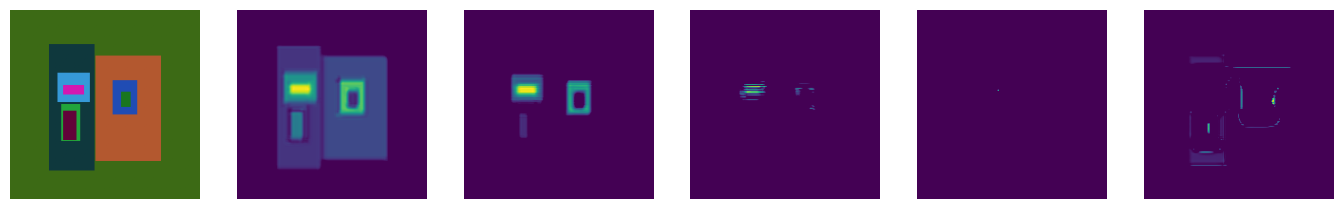

In [61]:
show_results(model, dRP500.test, 3)

### Exp - RP500, LSTM-CNN

In [105]:
model = RCNNCell(3, 200, 200, UnitProcess=UnitProcess2).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_RCNN_d2", comment="Lr_1e-5, BCE=4., deeper")
n_params(model)

14641

In [117]:
train(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(80, 100),
      dice=True)

Epoch 80: 2.6283501523052464
Epoch 81: 2.648644563716311
Epoch 82: 2.6922263218959643
Epoch 83: 2.664461076961831
Epoch 84: 2.6389496684319784
Epoch 85: 2.6346055397769623
Epoch 86: 2.63629299410965
Epoch 87: 2.6284584223350915
Epoch 88: 2.6250707975698027
Epoch 89: 2.6245431736714897
Epoch 90: 2.6353396080831066
Epoch 91: 2.6549210437707553
Epoch 92: 2.653559258965247
Epoch 93: 2.640345098751498
Epoch 94: 2.6369185012509258
Epoch 95: 2.629304309967462
Epoch 96: 2.6253629344841105
Epoch 97: 2.6248946809638314
Epoch 98: 2.621339068602273
Epoch 99: 2.6207978423907963


In [118]:
torch.save(model, "./models/RP500_RNN_CNN_deep.pth")

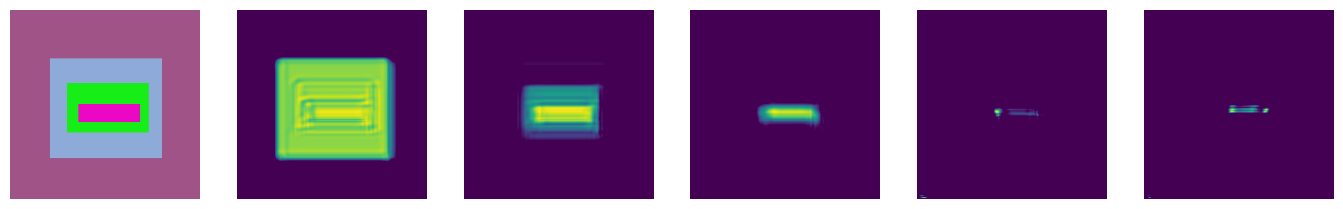

In [123]:
show_results(model, dRP500.val, 2)

### Exp - RP500, RCNN group

In [41]:
model =  RCNN(rcnn_cell=lambda *x: RCNNCell(*x),
             n_cells=2,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_RCNN_Group_ortho", comment="BCE=4.0,lr=1e-4,cells=2,ortho_init")
n_params(model)

1012

In [35]:
train_group(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, 10)
      )

Epoch 0: 2.8564747847130705
Epoch 1: 2.8512153672517377
Epoch 2: 2.851197821872854
Epoch 3: 2.8511979019962244
Epoch 4: 2.8511979019962244
Epoch 5: 2.8511979019962244
Epoch 6: 2.8511979019962244
Epoch 7: 2.8511979019962244
Epoch 8: 2.8511979019962244
Epoch 9: 2.8511979019962244


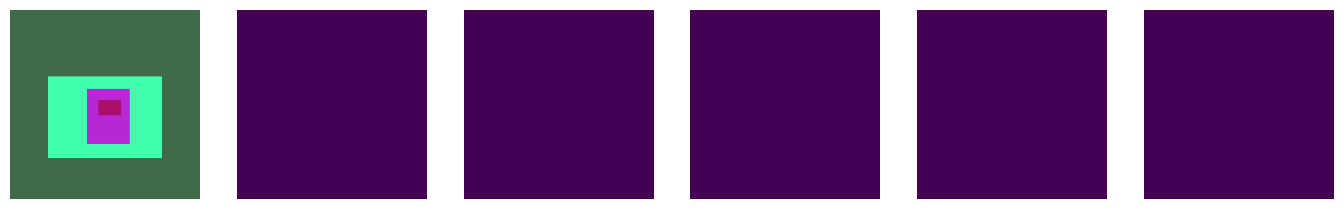

In [21]:
show_results_group(model, dRP500.train, 4)

Can't train

### Exp - RP500, LSTM-CNN group

In [45]:
model = RCNN(rcnn_cell=lambda *x: RLSTMCell(*x),
             n_cells=2,
             in_channels=3,
             height=200,
             width=200,
             out_channels=1).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_LSTM_Group_ortho_clip", comment="BCE=4.0,lr=1e-4,cells=4 ortho init with clipping")
n_params(model)

2400

In [46]:
train_group(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(0, 10)
      )

Epoch 0: 2.610196255184271
Epoch 1: 2.115631342119953
Epoch 2: 1.9034070779793755
Epoch 3: 1.7822841977964656
Epoch 4: 1.7239764015065087
Epoch 5: 1.6982625248459415
Epoch 6: 1.674251758210587
Epoch 7: 1.647503039968345
Epoch 8: 1.632618001268118
Epoch 9: 1.6189249484878911


Exploding gradient, clipping doesn't work

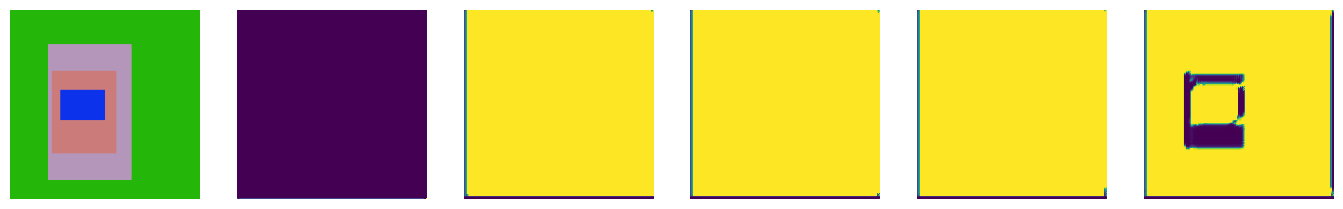

In [47]:
show_results_group(model, dRP500.train, 2)

### Exp - RP500, SegNet implementation

In [ ]:
SegNet = lambda x, y: nn.Sequential(
    nn.Conv2d(x, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 128, 3, 1, 1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Dropout(0.05),
    
    nn.ConvTranspose2d(128, 64, 2, 2),
    nn.Conv2d(64, 64, 3, 1, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    
    nn.ConvTranspose2d(64, 32, 2, 2),
    nn.Conv2d(32, 32, 3, 1, 1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(32, y, 3, 1, 1),
    
)

In [35]:
model = RCNNCell(3, 200, 200, UnitProcess=SegNet).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_RCNN_SegNet/4", comment="BCE_pos=4.0, segnet, lr=1e-4, dropout")

In [43]:
train(dRP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(50, 100),
      dice=True
      )

Epoch 50: 2.536123527223472
Epoch 51: 2.5346589926218304
Epoch 52: 2.5328439079954945
Epoch 53: 2.531970390742943
Epoch 54: 2.531590075764868
Epoch 55: 2.535396984259802
Epoch 56: 2.5869604546306584
Epoch 57: 2.5558665859208025
Epoch 58: 2.5381567047371805
Epoch 59: 2.533958183506039
Epoch 60: 2.5329889093542586
Epoch 61: 2.53836498603083
Epoch 62: 2.531923004129184
Epoch 63: 2.5308216661540524
Epoch 64: 2.5337558041711365
Epoch 65: 2.531808437539452
Epoch 66: 2.530602525161295
Epoch 67: 2.530078076169244
Epoch 68: 2.5304094620662583
Epoch 69: 2.5417237082378223
Epoch 70: 2.5523064093990455
Epoch 71: 2.561971349419136
Epoch 72: 2.546830456612462
Epoch 73: 2.5326377159359637
Epoch 74: 2.53049977147207
Epoch 75: 2.5295193656159674
Epoch 76: 2.5287913287063613
Epoch 77: 2.5285030273856997
Epoch 78: 2.5282962019474784
Epoch 79: 2.528505035288353
Epoch 80: 2.539938713455637
Epoch 81: 2.5412458111741674
Epoch 82: 2.5314350510632093
Epoch 83: 2.5294278614458996
Epoch 84: 2.52843080969792
Epoc

In [44]:
torch.save(model, "./models/RP500_RSegNetDrop.pth")

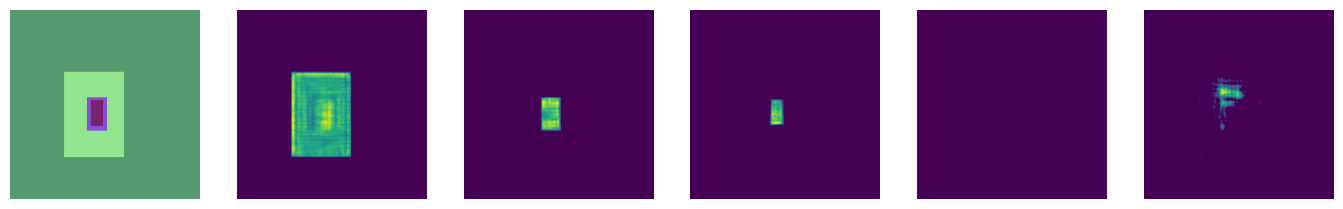

In [51]:
show_results(model, dRP500.train, 12)

### Exp -  RP500, CNN-GRU implementation

Meant for one-to-one implementation - not suitable

In [53]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn import init
from torch.autograd import Variable


class ConvGRUCell(Model):
    """
    Generate a convolutional GRU cell
    """

    def __init__(self, input_size, hidden_size, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.reset_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)
        self.update_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)
        self.out_gate = nn.Conv2d(input_size + hidden_size, hidden_size, kernel_size, padding=padding)

        init.orthogonal_(self.reset_gate.weight)
        init.orthogonal_(self.update_gate.weight)
        init.orthogonal_(self.out_gate.weight)
        init.constant_(self.reset_gate.bias, 0.)
        init.constant_(self.update_gate.bias, 0.)
        init.constant_(self.out_gate.bias, 0.)


    def forward(self, input_, prev_state):

        # get batch and spatial sizes
        batch_size = input_.data.size()[0]
        spatial_size = input_.data.size()[2:]

        # generate empty prev_state, if None is provided
        if prev_state is None:
            state_size = [batch_size, self.hidden_size] + list(spatial_size)
            if torch.cuda.is_available():
                prev_state = Variable(torch.zeros(state_size)).cuda()
            else:
                prev_state = Variable(torch.zeros(state_size))

        # data size is [batch, channel, height, width]
        stacked_inputs = torch.cat([input_, prev_state], dim=1)
        update = F.sigmoid(self.update_gate(stacked_inputs))
        reset = F.sigmoid(self.reset_gate(stacked_inputs))
        out_inputs = F.tanh(self.out_gate(torch.cat([input_, prev_state * reset], dim=1)))
        new_state = prev_state * (1 - update) + out_inputs * update

        return new_state


class ConvGRU(Model):

    def __init__(self, input_size, hidden_sizes, kernel_sizes, n_layers):
        '''
        Generates a multi-layer convolutional GRU.
        Preserves spatial dimensions across cells, only altering depth.

        Parameters
        ----------
        input_size : integer. depth dimension of input tensors.
        hidden_sizes : integer or list. depth dimensions of hidden state.
            if integer, the same hidden size is used for all cells.
        kernel_sizes : integer or list. sizes of Conv2d gate kernels.
            if integer, the same kernel size is used for all cells.
        n_layers : integer. number of chained `ConvGRUCell`.
        '''

        super(ConvGRU, self).__init__()

        self.input_size = input_size

        if type(hidden_sizes) != list:
            self.hidden_sizes = [hidden_sizes]*n_layers
        else:
            assert len(hidden_sizes) == n_layers, '`hidden_sizes` must have the same length as n_layers'
            self.hidden_sizes = hidden_sizes
        if type(kernel_sizes) != list:
            self.kernel_sizes = [kernel_sizes]*n_layers
        else:
            assert len(kernel_sizes) == n_layers, '`kernel_sizes` must have the same length as n_layers'
            self.kernel_sizes = kernel_sizes

        self.n_layers = n_layers

        cells = []
        for i in range(self.n_layers):
            if i == 0:
                input_dim = self.input_size
            else:
                input_dim = self.hidden_sizes[i-1]

            cell = ConvGRUCell(input_dim, self.hidden_sizes[i], self.kernel_sizes[i])
            name = 'ConvGRUCell_' + str(i).zfill(2)

            setattr(self, name, cell)
            cells.append(getattr(self, name))

        self.cells = cells


    def forward(self, x, hidden=None):
        '''
        Parameters
        ----------
        x : 4D input tensor. (batch, channels, height, width).
        hidden : list of 4D hidden state representations. (batch, channels, height, width).

        Returns
        -------
        upd_hidden : 5D hidden representation. (layer, batch, channels, height, width).
        '''
        if not hidden:
            hidden = [None]*self.n_layers

        input_ = x

        upd_hidden = []

        for layer_idx in range(self.n_layers):
            cell = self.cells[layer_idx]
            cell_hidden = hidden[layer_idx]

            # pass through layer
            upd_cell_hidden = cell(input_, cell_hidden)
            upd_hidden.append(upd_cell_hidden)
            # update input_ to the last updated hidden layer for next pass
            input_ = upd_cell_hidden

        # retain tensors in list to allow different hidden sizes
        return upd_hidden

In [67]:
model = ConvGRU(3, 
                hidden_sizes=[32,64,16,1],
                kernel_sizes=[3, 5, 3], 
                n_layers=3).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/RP500_CNNGRU", comment="BCE=4.0,lr=1e-4,cells=3")
n_params(model)

321

In [79]:
n_epochs = (0, 10)
dataset = dRP500
device = 'cuda'
for epoch in range(*n_epochs):
    epoch_loss = 0
    for data in dataset.train:        
        image, annotation = data
        image = image.to(device).unsqueeze(dim=0)
        
        optimizer.zero_grad()
        
        output = model(image)
        
        l = 0
    
        for weight, ann in enumerate(annotation):
            ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0)
            l += loss(output[-1], ann)
            # next step input                
            output = model(image)
        
        l.backward()
        
        optimizer.step()
    
        epoch_loss += float(l)
        
    epoch_loss /= len(dataset.train)
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    print(f"Epoch {epoch}: {epoch_loss}")
        
    # val
    with torch.inference_mode():
        val_loss = 0
        for data in dataset.val:
            
            image, annotation = data
            image = image.to(device).unsqueeze(dim=0)
            
            output = model(image)
            
            l = 0
        
            for weight, ann in enumerate(annotation):
                ann = torch.tensor(ann).to("cuda").unsqueeze(dim=0).unsqueeze(dim=0)
                l += loss(output[-1], ann)
                # next step input                
                output = model(image)
                
            val_loss += float(l)
            
        val_loss /= len(dataset.val)
        writer.add_scalar("Loss/val", val_loss, epoch)
        writer.add_scalar("GradNorm", model.grad_norm(), epoch)
        
if False:
    for i, thresh in enumerate(np.arange(0, 1, 0.1)):
        writer.add_scalar("Dice/train", dice_score(model, dataset.train, thresh), i)
        writer.add_scalar("Dice/val", dice_score(model, dataset.val, thresh), i)

Epoch 0: 3.133318409173952
Epoch 1: 3.085067173441447
Epoch 2: 3.063026823169803
Epoch 3: 3.05093120703727
Epoch 4: 3.0434626041270265
Epoch 5: 3.0384654665361843
Epoch 6: 3.0349227859601844
Epoch 7: 3.032299765622825
Epoch 8: 3.0302911689486147
Epoch 9: 3.028711493329313


In [80]:
len(annotation)

4

## PP500

### Exp - PP500, R-CNN

In [29]:
s = 300
model = RCNNCell(3, s, s).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/PP500/RCNN_3", comment="BCE_pos=4.0, lr=1e-4")
n_params(model)

898

In [32]:
train(dPP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(20, 100),
      norm=255.0,
      dice=True)

Epoch 20: 2.393848856687546
Epoch 21: 2.393811448216438
Epoch 22: 2.3937813356518745
Epoch 23: 2.3937566164135933
Epoch 24: 2.393736793398857
Epoch 25: 2.3937209671735764
Epoch 26: 2.393708128333092
Epoch 27: 2.3936976447701452
Epoch 28: 2.393689205646515
Epoch 29: 2.393682363629341
Epoch 30: 2.393676751255989
Epoch 31: 2.3936722004413604
Epoch 32: 2.3936685904860497
Epoch 33: 2.3936657598614692
Epoch 34: 2.393663528561592
Epoch 35: 2.3936617097258566
Epoch 36: 2.3936602333188057
Epoch 37: 2.3936589816212654
Epoch 38: 2.3936579367518425
Epoch 39: 2.393657063245773
Epoch 40: 2.3936563417315484
Epoch 41: 2.393655770123005
Epoch 42: 2.393655317723751
Epoch 43: 2.393654952645302
Epoch 44: 2.393654681146145
Epoch 45: 2.3936544665694237
Epoch 46: 2.393654297888279
Epoch 47: 2.3936541506648066
Epoch 48: 2.3936540511250497
Epoch 49: 2.393653973042965
Epoch 50: 2.3936539003252983
Epoch 51: 2.3936538460850714
Epoch 52: 2.3936537888646128
Epoch 53: 2.393653751015663
Epoch 54: 2.393653719425201
Ep

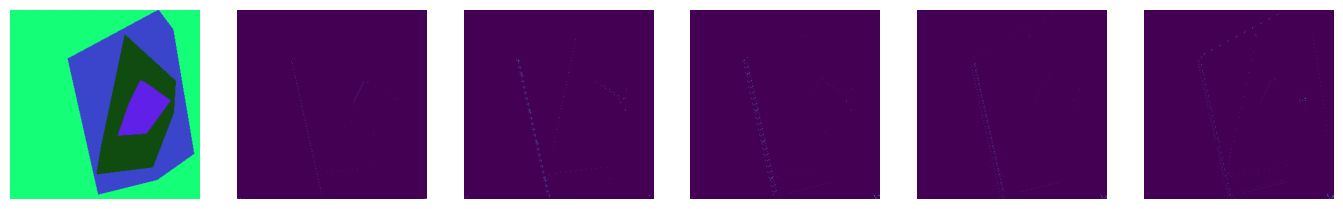

In [31]:
show_results(model, dPP500.val, 4, height=300, width=300)

### Exp - PP500, LSTM Cell

In [33]:
model = RLSTMCell(3, 300, 300).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.).cuda())
writer = SummaryWriter(f"./runs/PP500/RLSSTM_1", comment="Lr_1e-5, BCE=4., deeper")
n_params(model)

2096

In [36]:
train(dPP500,
      model,
      optimizer,
      loss,
      writer,
      n_epochs=(20,100),
      norm=255.0,
      dice=True)

Epoch 20: 1.2921749085187912
Epoch 21: 1.279329631626606
Epoch 22: 1.2670907312631607
Epoch 23: 1.2556497110426426
Epoch 24: 1.2448167821764946
Epoch 25: 1.234610108435154
Epoch 26: 1.2248501327633858
Epoch 27: 1.2152907918393612
Epoch 28: 1.2065621073544026
Epoch 29: 1.198028425425291
Epoch 30: 1.189289794266224
Epoch 31: 1.1811091877520083
Epoch 32: 1.1733041717112065
Epoch 33: 1.1659489931166171
Epoch 34: 1.1589627465605736
Epoch 35: 1.152561944425106
Epoch 36: 1.1468489199876786
Epoch 37: 1.1417249640822411
Epoch 38: 1.1369614613056183
Epoch 39: 1.132418892979622
Epoch 40: 1.1283044986426831
Epoch 41: 1.1246165238320827
Epoch 42: 1.1212534010410309
Epoch 43: 1.1182077305018903
Epoch 44: 1.1153958690166474
Epoch 45: 1.1128673043847084
Epoch 46: 1.1105755564570428
Epoch 47: 1.1085090903937818
Epoch 48: 1.1066280090808869
Epoch 49: 1.1049526451528073
Epoch 50: 1.1034969580173493
Epoch 51: 1.1021952514350415
Epoch 52: 1.1009967787563801
Epoch 53: 1.0998894725739956
Epoch 54: 1.09890501

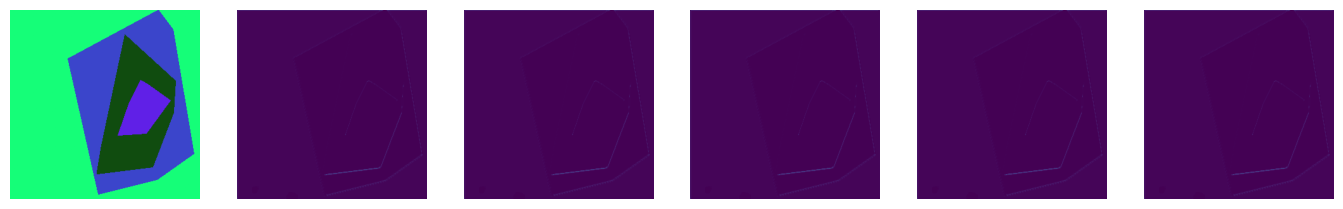

In [37]:
show_results(model, dPP500.val, 4, height=300, width=300)